<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/PET_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [2]:
import os
import glob
import random
import json
import warnings
from collections import defaultdict
from monai.transforms import (EnsureChannelFirstd, Compose, LoadImaged, Spacingd, Resized)
from monai.data import CacheDataset, DataLoader
import numpy as np
import random
from collections import defaultdict
from monai.data import Dataset
from monai.utils import first, set_determinism
import matplotlib.pyplot as plt
import torch
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd


In [3]:
root_dir ="/home/shahpouriz/Data/Code_Sama/ASC-PET-001"

## Set dataset path

In [29]:

train_images = sorted(glob.glob(os.path.join(root_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(root_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]

# making  smaller input to save time for practing stage:
# train_files, val_files =  data_dicts[:20], data_dicts[-5:]
train_files, val_files =  data_dicts[:], data_dicts[:]

data_files = [file_info['image'] for file_info in val_files]  # Combine train and validation files if needed



In [34]:
len(data_files)

184

In [6]:
from monai.transforms import LoadImage

# Function to load an image and print its size
def print_image_size(file_info):
    loader = LoadImage(image_only=True)
    image = loader(file_info['image'])
    print(f"Image size: {image.shape}")

# # Print sizes of the last few images in the train_files
# print("Train Files:")
# for file_info in train_files:  # Adjust the number as needed
#     print_image_size(file_info)

# Print sizes of the last few images in the val_files
print("\nValidation Files:")
for file_info in val_files:  # Adjust the number as needed
    print_image_size(file_info)




Validation Files:
Image size: torch.Size([180, 180, 317])
Image size: torch.Size([180, 180, 346])
Image size: torch.Size([180, 180, 346])
Image size: torch.Size([180, 180, 317])
Image size: torch.Size([180, 180, 317])


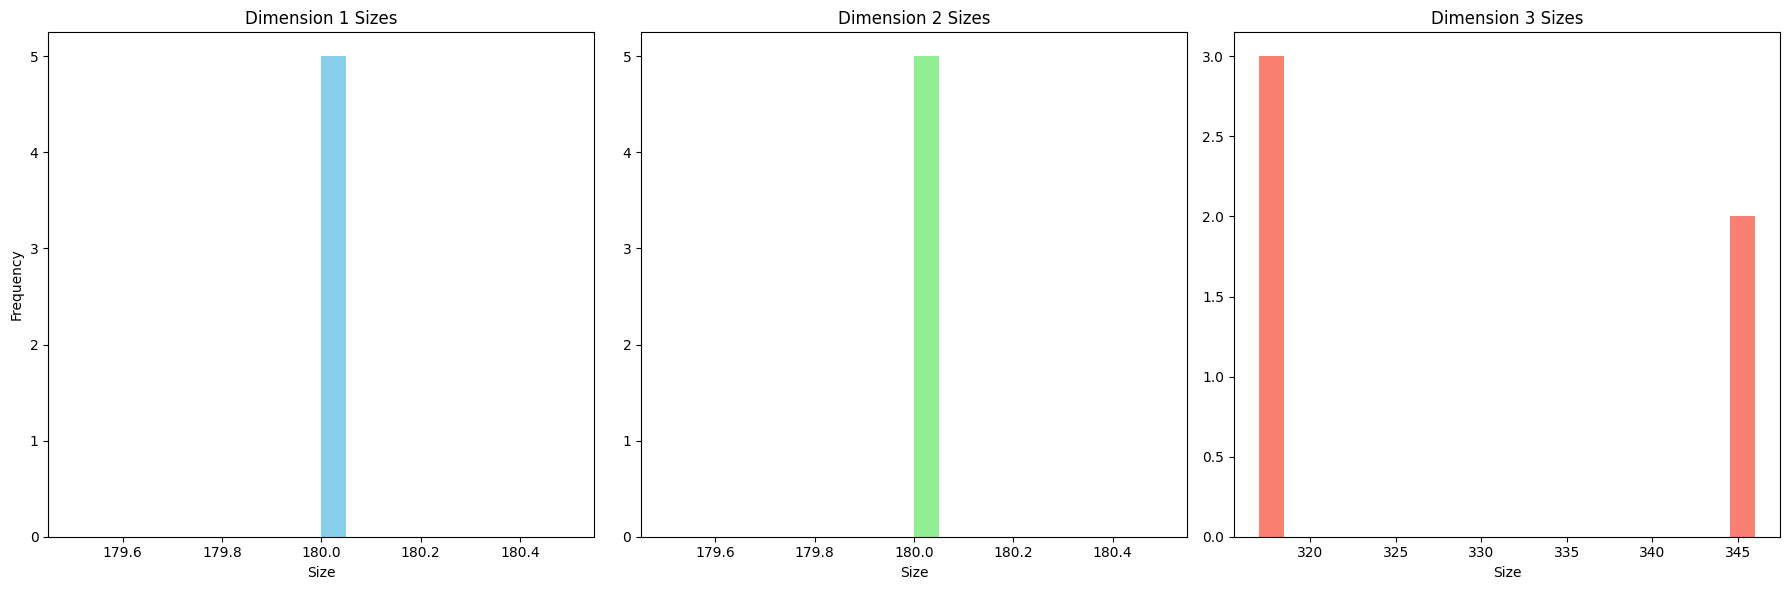

In [7]:
from monai.transforms import LoadImage
import matplotlib.pyplot as plt

# Assuming val_files is a list of dictionaries with 'image' keys
image_sizes = []
loader = LoadImage(image_only=True)

# Collect image sizes
for file_info in val_files:
    image = loader(file_info['image'])
    image_sizes.append(image.shape)

# Extracting dimensions
dims1 = [size[0] for size in image_sizes]
dims2 = [size[1] for size in image_sizes]
dims3 = [size[2] for size in image_sizes]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].hist(dims1, bins=20, color='skyblue')
axs[0].set_title('Dimension 1 Sizes')
axs[0].set_xlabel('Size')
axs[0].set_ylabel('Frequency')

axs[1].hist(dims2, bins=20, color='lightgreen')
axs[1].set_title('Dimension 2 Sizes')
axs[1].set_xlabel('Size')

axs[2].hist(dims3, bins=20, color='salmon')
axs[2].set_title('Dimension 3 Sizes')
axs[2].set_xlabel('Size')

plt.tight_layout()
plt.show()


In [8]:
# def print_image_info(file_info, transforms):
#     loader = LoadImage(image_only=True)
#     image = loader(file_info['image'])
#     print(f"Original image size: {image.shape}")
    
#     # Apply transformations
#     transformed_image = transforms(file_info)
#     print(f"Transformed image size: {transformed_image['image'].shape}")

# # Define your transforms
# train_transforms = Compose([
#     LoadImaged(keys=["image", "target"]),
#     EnsureChannelFirstd(keys=["image", "target"]),
#     Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
#     SpatialPadd(keys=["image", "target"], spatial_size=[96, 96, 96], mode='constant', method='symmetric'),
# ])

# # # Example usage
# # print("Train Files:")
# # for file_info in train_files[-5:]:  # Adjust the number as needed
# #     print_image_info(file_info, train_transforms)

# print("\nValidation Files:")
# for file_info in val_files[-5:]:  # Adjust the number as needed
#     print_image_info(file_info, train_transforms)


-------------
# Check voxel spacing

In [38]:
def get_voxel_spacing(file_path):
    loader = LoadImage(image_only=False)  # Load image and metadata
    _, meta_data = loader(file_path)
    # The first element of 'pixdim' is often 1 and not used for spacing,
    # so we take the next three elements which represent the voxel spacings in X, Y, and Z.
    spacing = meta_data['pixdim'][1:4]  # Extract voxel spacing from 'pixdim'
    return spacing

voxel_spacings = np.array([get_voxel_spacing(file_path) for file_path in data_files])

voxel_spacings

array([[4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.       ],
       [4.07283  , 4.07283  , 3.  

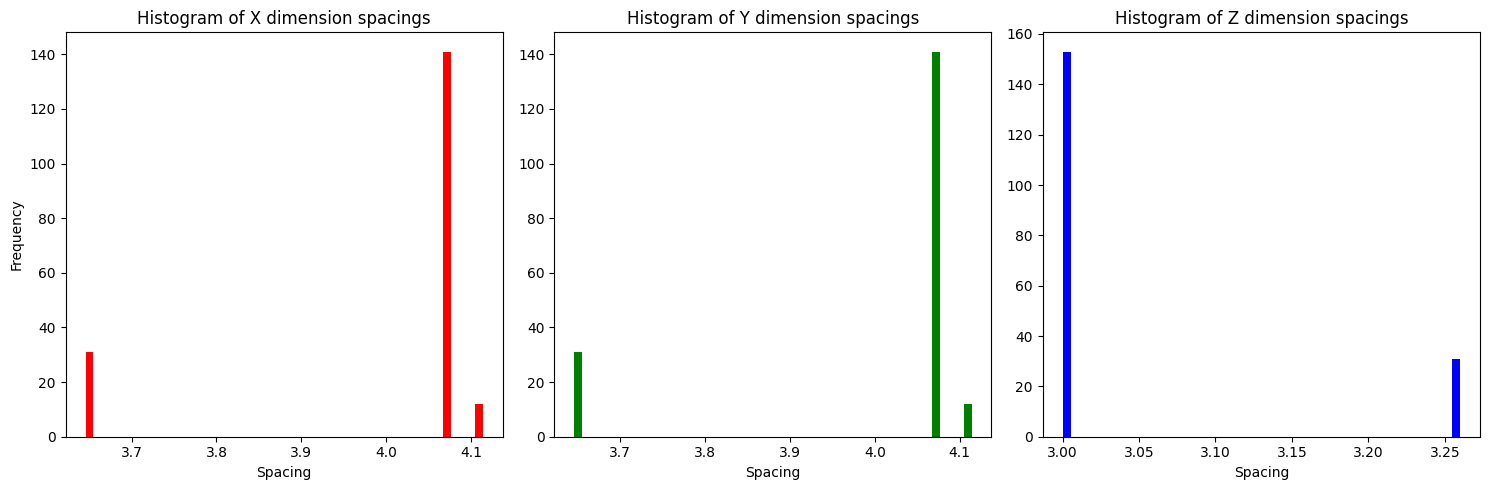

In [39]:
# Assuming voxel_spacings is an Nx3 array where N is the number of images, and each row is the spacing (x, y, z)
plt.figure(figsize=(15, 5))

# X dimension spacings
plt.subplot(1, 3, 1)
plt.hist(voxel_spacings[:, 0], bins=50, color='r')
plt.title('Histogram of X dimension spacings')
plt.xlabel('Spacing')
plt.ylabel('Frequency')

# Y dimension spacings
plt.subplot(1, 3, 2)
plt.hist(voxel_spacings[:, 1], bins=50, color='g')
plt.title('Histogram of Y dimension spacings')
plt.xlabel('Spacing')

# Z dimension spacings
plt.subplot(1, 3, 3)
plt.hist(voxel_spacings[:, 2], bins=50, color='b')
plt.title('Histogram of Z dimension spacings')
plt.xlabel('Spacing')

plt.tight_layout()
plt.show()


In [40]:
from scipy.stats import mode

# Since mode() returns a scalar, we no longer try to index it with [0]
most_common_spacing_x = mode(np.round(voxel_spacings[:, 0], decimals=2)).mode
most_common_spacing_y = mode(np.round(voxel_spacings[:, 1], decimals=2)).mode
most_common_spacing_z = mode(np.round(voxel_spacings[:, 2], decimals=2)).mode

print(f"Most common voxel spacing in X dimension: {most_common_spacing_x}")
print(f"Most common voxel spacing in Y dimension: {most_common_spacing_y}")
print(f"Most common voxel spacing in Z dimension: {most_common_spacing_z}")


Most common voxel spacing in X dimension: 4.070000171661377
Most common voxel spacing in Y dimension: 4.070000171661377
Most common voxel spacing in Z dimension: 3.0


-------------
# Test details

In [12]:
from scipy.stats import mode
test_mode_result_x = mode(np.round(voxel_spacings[:, 0], decimals=2))
print("Mode Result X:", test_mode_result_x)
print("Mode X:", test_mode_result_x.mode)


Mode Result X: ModeResult(mode=4.11, count=5)
Mode X: 4.11


In [13]:
print("Mode Result X Shape:", test_mode_result_x.mode.shape)
print("Type of Mode Result X:", type(test_mode_result_x.mode))


Mode Result X Shape: ()
Type of Mode Result X: <class 'numpy.float32'>


In [14]:
print("Voxel Spacings Shape:", voxel_spacings.shape)
print("Type of Voxel Spacings:", type(voxel_spacings))


Voxel Spacings Shape: (5, 3)
Type of Voxel Spacings: <class 'numpy.ndarray'>


In [15]:
print("First Element:", voxel_spacings[0, :])


First Element: [4.11392 4.11392 3.     ]


In [16]:
most_common_spacing_x = np.round(voxel_spacings[:, 0], decimals=2)
mode_result_x = mode(most_common_spacing_x)
print("Most Common Spacing X:", mode_result_x.mode if mode_result_x.mode.size else "No mode found")


Most Common Spacing X: 4.11


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/home/shahpouriz/Data/new_env/lib64/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


----------
# Pixel Values

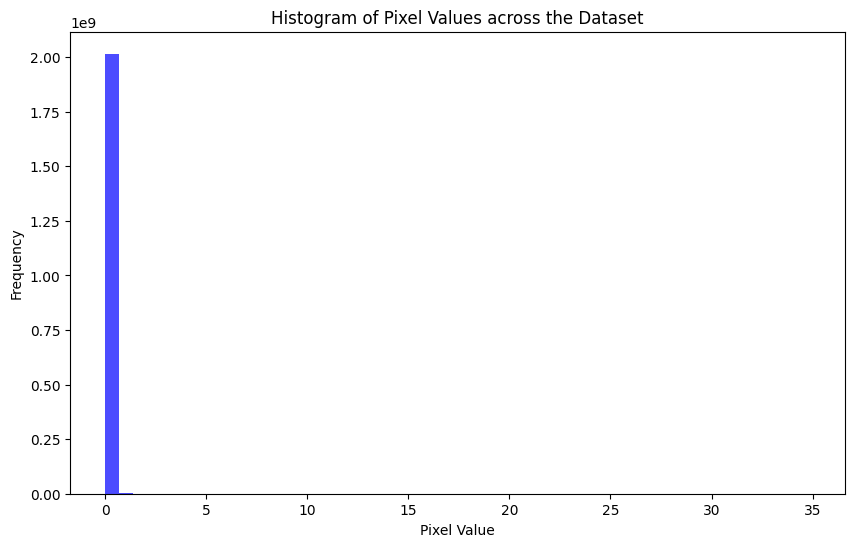

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Initialize a list to store all pixel values
all_pixel_values = []

# Assuming 'data_files' is a list of file paths for your dataset
for file_path in data_files:
    # Load the image
    image = LoadImage(image_only=True)(file_path)
    
    # Convert the image to a numpy array if it's not already
    image_np = np.array(image)
    
    # Flatten the image array to get a list of all pixel values in the image
    pixels = image_np.flatten()
    
    # Append these pixel values to the aggregate list
    all_pixel_values.extend(pixels)

# Convert the list of all pixel values to a numpy array
all_pixel_values_np = np.array(all_pixel_values)



Mean of scaled pixel values: 0.0171526949852705
Maximum of scaled pixel values: 34.86298751831055


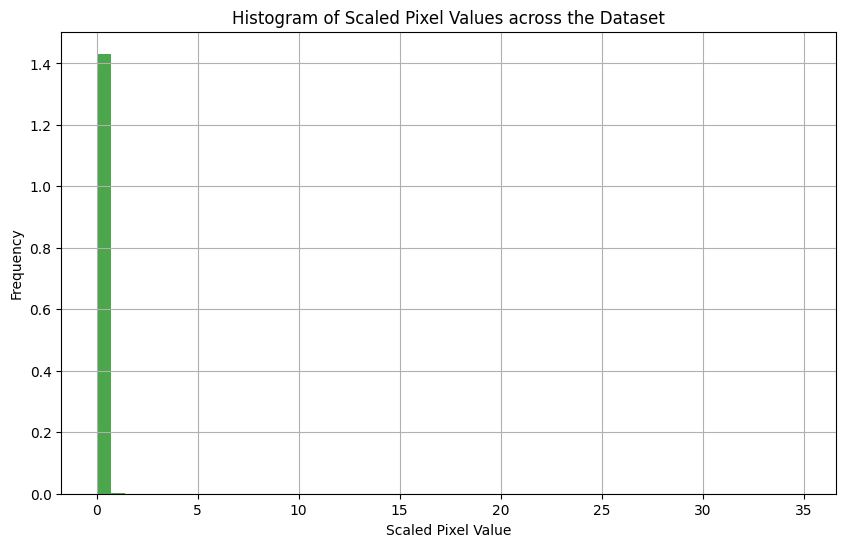

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming all_pixel_values_np contains all the pixel values from the dataset

# Calculate mean and max of the scaled pixel values
mean_value = np.mean(all_pixel_values_np)
max_value = np.max(all_pixel_values_np)

# Printing statistical information
print(f"Mean of scaled pixel values: {mean_value}")
print(f"Maximum of scaled pixel values: {max_value}")

# Plotting the histogram of scaled pixel values
plt.figure(figsize=(10, 6))
plt.hist(all_pixel_values_np, bins=50, color='green', alpha=0.7, density=True)
plt.title("Histogram of Scaled Pixel Values across the Dataset")
plt.xlabel("Scaled Pixel Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [36]:
len(data_files)

5

image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


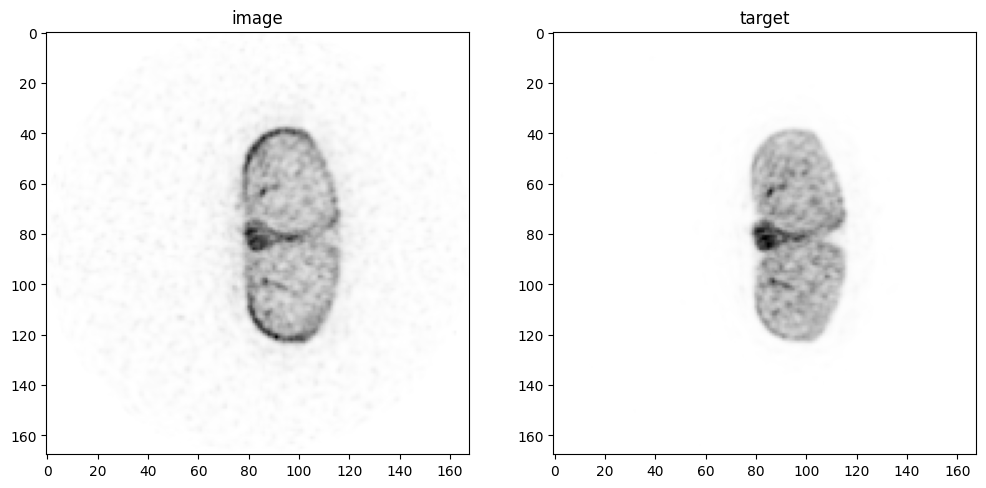

In [18]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 50



plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n],cmap='gist_yarg' )
plt.show()

In [19]:

import numpy as np

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")


image shape: torch.Size([168, 168, 320]), target shape: torch.Size([168, 168, 320])


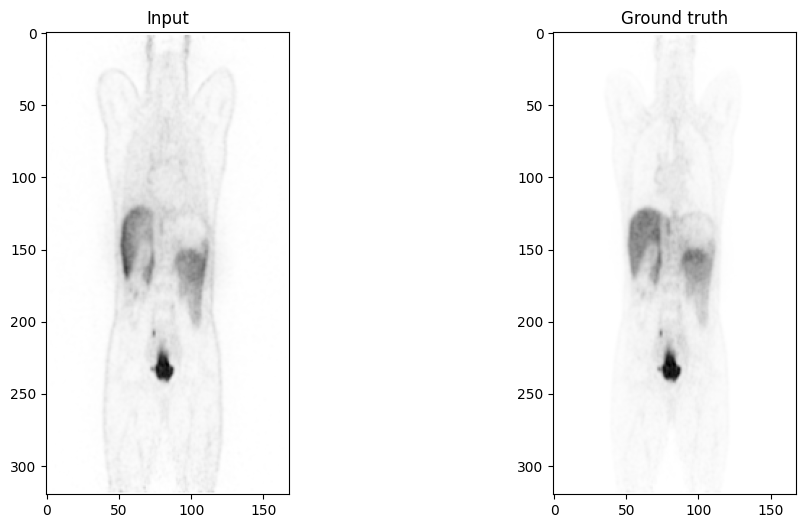

In [20]:

n = 90  # Selecting the slice

plt.figure(figsize=(12, 6))  # Correct way to set figure size
plt.subplot(1, 2, 1)
plt.title("Input")
# Rotate the slice and plot
input_slice = np.rot90(image[:, n, :])
plt.imshow(input_slice, cmap="gist_yarg")

plt.subplot(1, 2, 2)
plt.title("Ground truth")
# Rotate the slice and plot
target_slice = np.rot90(target[:, n, :])
plt.imshow(target_slice, cmap='gist_yarg')

plt.show()


-------------
# Transformers

In [21]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)


roi_size = [168, 168, 320]

val_transforms = Compose([
    LoadImaged(keys=["image", "target"]),
    EnsureChannelFirstd(keys=["image", "target"]),
    Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),  # Adjust spacing as needed
    SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant',  method='symmetric'),  # Pad to ensure minimum size
    ScaleIntensityd(keys=["image", "target"], minv=0.0, maxv=1.0),
    CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
])




train_ds = CacheDataset(data=train_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


In [22]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break

Batch 0 image size: torch.Size([4, 1, 168, 168, 320])
Batch 1 image size: torch.Size([4, 1, 168, 168, 320])
Batch 2 image size: torch.Size([4, 1, 168, 168, 320])


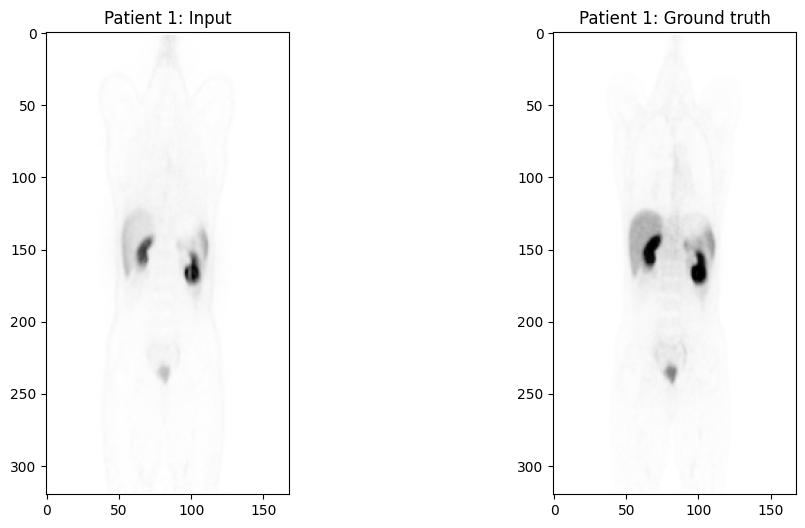

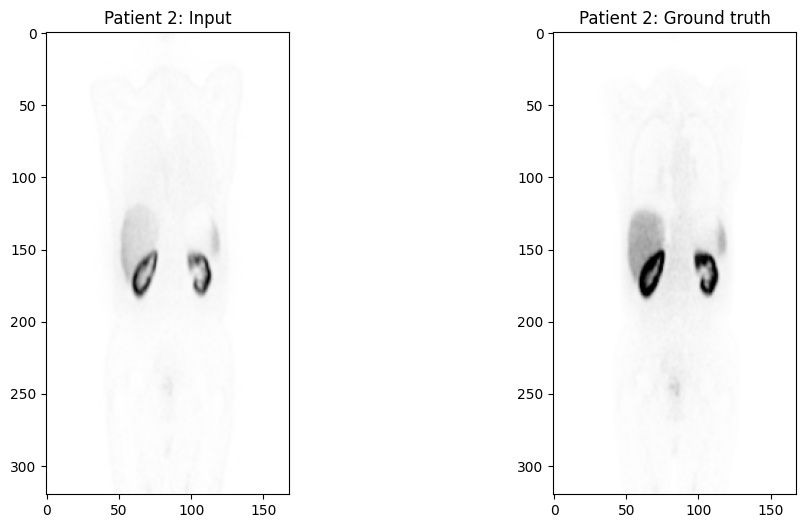

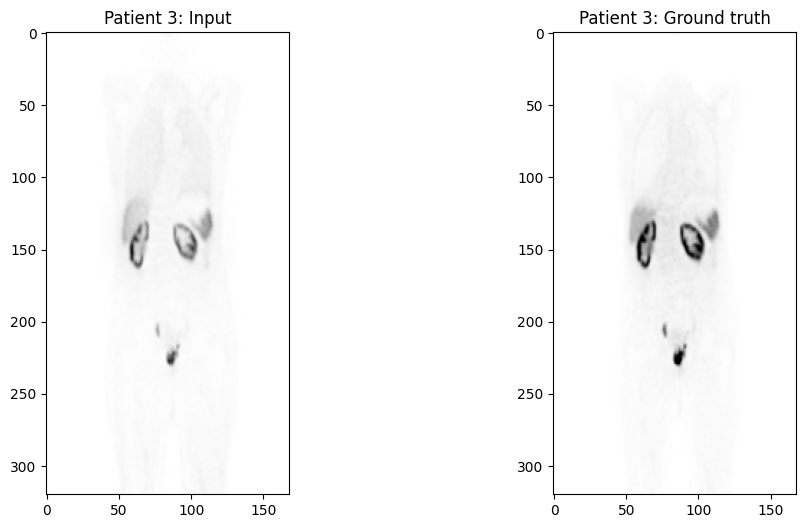

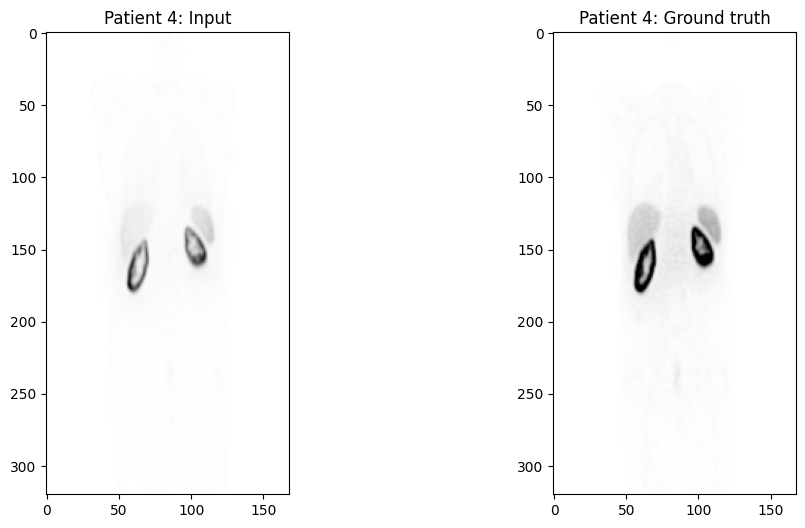

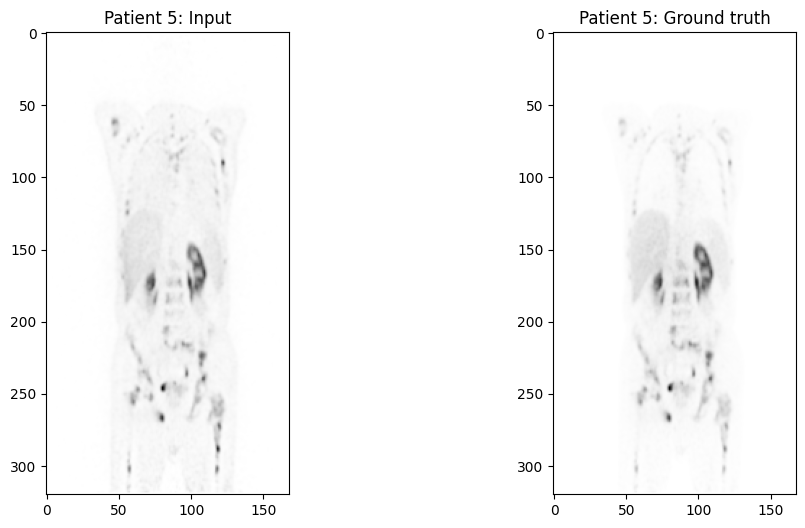

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from monai.data import DataLoader

# Assuming val_loader is already defined and loaded with your validation data
n = 95  # Selecting the slice

for i, data in enumerate(val_loader):
    image, target = (data["image"][0][0], data["target"][0][0])
    
    # Check if the selected slice index is within the bounds for the current image and target
    if n >= image.shape[1] or n >= target.shape[1]:  # Assuming the second dimension is the slice index
        print(f"Skipping patient {i+1}: slice index {n} is out of bounds for this patient.")
        continue

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"Patient {i+1}: Input")
    input_slice = np.rot90(image[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 2, 2)
    plt.title(f"Patient {i+1}: Ground truth")
    target_slice = np.rot90(target[:, n, :])  # Adjust the slice index position if needed
    plt.imshow(target_slice, cmap='gist_yarg')

    plt.show()


------------
# Apply transformers on test data


In [24]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensity
# from monai.inferers import SlidingWindowInferer

# # Assuming the same spacing and intensity normalization as training
# test_transforms = Compose([
#     LoadImaged(keys=["image"]),
#     EnsureChannelFirstd(keys=["image"]),
#     Spacingd(keys=["image"], pixdim=(4.07, 4.07, 3.0), mode=('bilinear')),
#     ScaleIntensity(keys=["image"]),  # Adjust based on your specific normalization used during training
#     # No need for SpatialPadd or cropping here
# ])

# # Sliding window inferer with the patch size used during training
# inferer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=1, overlap=0.5)

# # Assuming `model` is your trained model and `test_data` is a batch from your DataLoader
# test_data = next(iter(test_loader))  # Example to get a batch
# model.eval()
# with torch.no_grad():
#     # Apply transformations
#     test_data_transformed = test_transforms(test_data)
#     # Perform inference
#     preds = inferer(inputs=test_data_transformed["image"].unsqueeze(0), network=model)
#     # preds now contains the prediction for the whole volume


# **Create Model, Loss, Optimizer**

In [25]:
import json
import torch
from torch import nn
from monai.networks.nets import UNet
from monai.networks.layers import Norm


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [26]:
max_epochs = 10
val_interval = 2
best_metric = float('inf')
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
train_losses = []
val_losses = []

In [27]:


for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (batch_data["image"].to(device),
                           batch_data["target"].to(device),)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (val_data["image"].to(device),
                                           val_data["target"].to(device),)
                val_outputs = model(val_inputs)
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)
            val_losses.append(val_loss)
            print(f"Validation loss: {val_loss:.4f}")

            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_PET.pth"))
                print("Saved new best metric model")

print(f"Training completed. Best validation loss: {best_metric:.4f} at epoch {best_metric_epoch}")


----------
epoch 1/10
1/5, train_loss: 0.6833
2/5, train_loss: 1.1890
3/5, train_loss: 0.9384
4/5, train_loss: 0.7575
5/5, train_loss: 1.0431
epoch 1 average loss: 0.9223
----------
epoch 2/10
1/5, train_loss: 0.9290
2/5, train_loss: 0.9756
3/5, train_loss: 0.6186
4/5, train_loss: 0.7867
5/5, train_loss: 0.8220
epoch 2 average loss: 0.8264
Validation loss: 1.2986
Saved new best metric model
----------
epoch 3/10
1/5, train_loss: 0.5423
2/5, train_loss: 0.7777
3/5, train_loss: 0.7541
4/5, train_loss: 1.0621
5/5, train_loss: 0.7632
epoch 3 average loss: 0.7799
----------
epoch 4/10
1/5, train_loss: 0.7159
2/5, train_loss: 1.1039
3/5, train_loss: 0.6334
4/5, train_loss: 0.5590
5/5, train_loss: 0.7466
epoch 4 average loss: 0.7518
Validation loss: 1.2674
Saved new best metric model
----------
epoch 5/10
1/5, train_loss: 0.8597
2/5, train_loss: 0.6367
3/5, train_loss: 0.9005
4/5, train_loss: 0.7236
5/5, train_loss: 0.5604
epoch 5 average loss: 0.7362
----------
epoch 6/10
1/5, train_loss: 0.

KeyboardInterrupt: 

In [ ]:
import numpy as np
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure(figsize=(14, 6))  # Set the size of the figure

# Plotting the training and validation losses
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha = 0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))

plt.show()

100%|██████████| 7/7 [01:56<00:00, 16.66s/it]


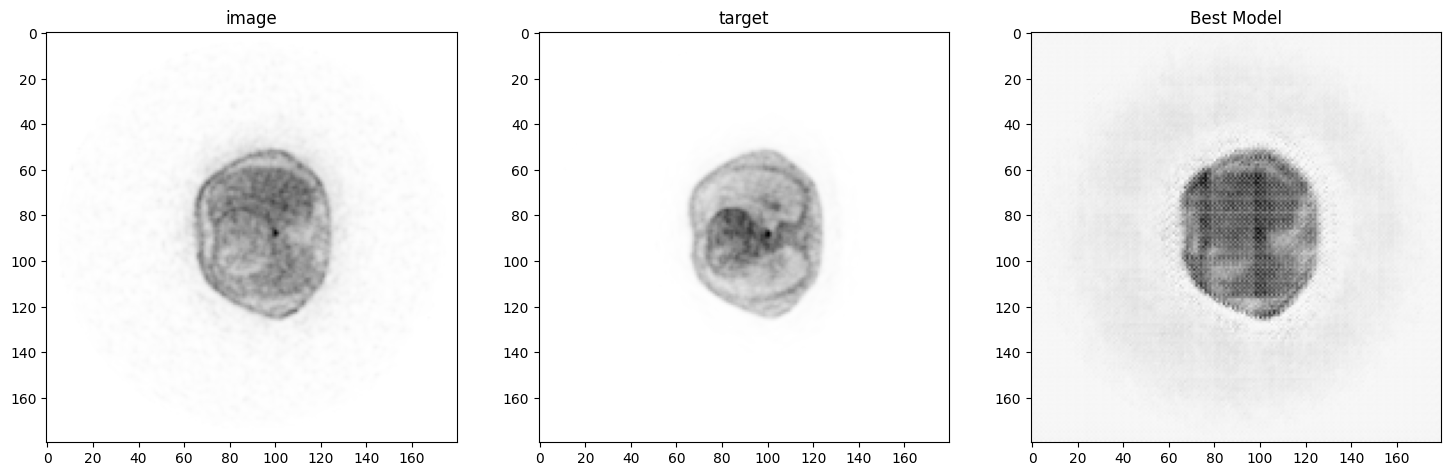

In [ ]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_PET.pth")))
model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




In [ ]:
#         if dice_after > best_eval_dice:
#             best_eval_dice = dice_after
#             if do_save:
#                 # Save best model based on Dice
#                 if pth_best_dice != "":
#                     os.remove(os.path.join(dir_save, pth_best_dice))
#                 pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
#                 torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
#                 print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

#     if do_save:
#         # Save latest model
#         if pth_latest != "":
#             os.remove(os.path.join(dir_save, pth_latest))
#         pth_latest = "segresnet_kpt_loss_latest.pth"
#         torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))


# # learn2reg_nlst_paired_lung_CT notbook